In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import calendar
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from keras.models import load_model
import h5py
import pickle
import gensim
import time
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import metrics
from gensim.models import KeyedVectors
from gensim.models import FastText
from gensim.models.wrappers import FastText
from gensim.models import Word2Vec
from keras.models import load_model
from enum import Enum
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 20, 7
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
df = pd.read_csv('CensusErrors.csv', encoding='utf8', dtype=object)

In [3]:
df.head(2)

,age,class_of_worker,education,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,...,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,year,income,label
0,10,not in universe,children,not in universe,never married,not in universe or children,not in universe,black,all other,female,...,yes,not in universe,united-states,united-states,united-states,native- born in the united states,0,x4,- 50000.,0
1,4,not in universe,children,not in universe,never married,not in universe or children,not in universe,white,all other,female,...,yes,not in universe,united-states,united-states,united-states,native- born in the united states,0,94,- 50000.,0


In [4]:
len(df)
sum(df.isnull().values.ravel())

12795

In [5]:
start = time.time()

In [6]:
dfEmpty = df[df.isnull().any(axis=1)]

In [7]:
dfEmpty = dfEmpty.apply(lambda x: x.astype(str).str.lower())

In [8]:
df_Nan = df
df_Nan = df_Nan[~df_Nan.isin(dfEmpty)].dropna()
df_Nan.to_csv("CensusErrorsWithoutNan.csv", index=False)

In [9]:
dfEmpty.drop(columns=['label'], axis=1, inplace=True)

In [10]:
path = "CensusWord2Vec.w2v"
word2vecModel = KeyedVectors.load(path)

In [11]:
mapping = dict(enumerate(dfEmpty.columns.astype('category').categories))

In [12]:
attributeMapping = {}
for i,idx in enumerate(dfEmpty.columns):
    attributeMapping[idx] = i

In [13]:
inverseMapping = {y:x for x,y in attributeMapping.items()}

In [14]:
inverseMapping

{0: 'age',
 1: 'class_of_worker',
 2: 'education',
 3: 'enroll_in_edu_inst_last_wk',
 4: 'marital_stat',
 5: 'major_industry_code',
 6: 'major_occupation_code',
 7: 'race',
 8: 'hispanic_origin',
 9: 'sex',
 10: 'member_of_a_labor_union',
 11: 'reason_for_unemployment',
 12: 'full_or_part_time_employment_stat',
 13: 'tax_filer_stat',
 14: 'region_of_previous_residence',
 15: 'state_of_previous_residence',
 16: 'detailed_household_and_family_stat',
 17: 'detailed_household_summary_in_household',
 18: 'migration_code_change_in_msa',
 19: 'migration_code_change_in_reg',
 20: 'migration_code_move_within_reg',
 21: 'live_in_this_house_1_year_ago',
 22: 'migration_prev_res_in_sunbelt',
 23: 'country_of_birth_father',
 24: 'country_of_birth_mother',
 25: 'country_of_birth_self',
 26: 'citizenship',
 27: 'own_business_or_self_employed',
 28: 'year',
 29: 'income'}

## Load Attribute Classifier

In [15]:
model = load_model('CensusMultiAttributeClassifier.h5')

In [16]:
with open('CensusMultiAttributeClassifierTokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

## Repair pipeline

In [17]:
def impute(word2vecModel, model, tokenizer, rowWithMissingValue, missingType, topN=10):
    """
    Returns the closest match for the missing attribute value
    """
    output = dict()
    for value in rowWithMissingValue:
        try:
            results = word2vecModel.wv.most_similar(value, topn=topN)
            for match, confidence in results:
                # Predicted type to be equal to the missing value
                if predictAttribute(model, tokenizer, match) == missingType:
                    if match in output and confidence <= output[match]:
                        continue
                    else:
                        output[match] = confidence            
        except KeyError:
            continue
    return output.items()

In [18]:
def predictAttribute(model, tokenizer, value):
    """
    Classifies value parameter as its corresponding attribute
    """
    value = [value]
    sequences = tokenizer.texts_to_sequences(value)
    testData = pad_sequences(sequences, maxlen=48)
    predictions = model.predict(testData)
    return attributeMapping[mapping[np.argmax(predictions[0])]]

In [19]:
nullRows = dfEmpty.values.tolist()
rows = []
#columnNames = ['ProviderNumber', 'HospitalName', 'Address1', 'City', 'ZipCode', 'CountyName', 'PhoneNumber','HospitalOwner','Condition','Sample']
columnNames = dfEmpty.columns.tolist()
for row in nullRows:
    missingAttribute = None
    removedNan = []
    for i in range(len(row)):
        if str(row[i]) != 'nan':
            removedNan.append(row[i])
        else:
            missingAttribute = attributeMapping[columnNames[i]]
    if missingAttribute is not None:
        rows.append({tuple(removedNan):missingAttribute})
    else:
        print(row)

## Imputation

In [20]:
def getImputedValue(missingRow, attributeType):
    results = impute(word2vecModel, model, tokenizer, missingRow, attributeType, 100)
    return sorted(results, key=lambda x: x[1], reverse=True)[0] if results else None

## Build verification pipeline

In [21]:
dfClean = pd.read_csv('clean_census_dataset.csv', encoding='utf8', dtype='object')
dfClean.drop(columns=['label'], axis=1, inplace=True)

In [22]:
dfUnique = dfClean.drop_duplicates()

In [23]:
queryMapping = {}
attributeNames = dfClean.columns.tolist()
for i in attributeNames:
    for j in attributeNames:
        if i!=j:
            if i in queryMapping:
                queryMapping[i] = queryMapping.get(i) + ' and  ' + str(j + '=="{}"')
            else:
                queryMapping[i] = str(j + '=="{}"') 

In [24]:
correct = 0
inCorrect = 0
incorrectPredictions = []

In [25]:
count = 0
for row in rows:
    missingRow = list(row.keys())[0]
    attribute = list(row.values())[0]
    missingRow = [i.strip() for i in missingRow]
    # Run the query
    query = (queryMapping[inverseMapping[attribute]]).format(*missingRow)
    
    outputDf = dfClean.query(query)
    actual = outputDf.head(1)[inverseMapping[attribute]].to_string(index=False)
    if actual == 'empty':
        continue
    predicted = getImputedValue(missingRow, attribute) 
    if predicted and actual == predicted[0]:
        correct += 1
    else:
        inCorrect += 1
        incorrectPredictions.append((actual, predicted[0] if predicted else None)) 

## Read data
Details here: https://fasttext.cc/

## For truth validation read clean dataset

In [26]:
df_truth = pd.read_csv('clean_census_dataset.csv',dtype=object, encoding='utf8', index_col=False)
df_truth.replace(np.nan,'empty',inplace = True)
df_truth.drop(columns=['label'], axis=1, inplace=True)

## Read dirty dataset from imputation

In [27]:
df_dirty = pd.read_csv('CensusErrorsWithoutNan.csv',dtype=object, encoding='utf8', index_col=False)
df_dirty.drop(columns=['label'], axis=1, inplace=True)

In [28]:
df_truth.head(2)

,age,class_of_worker,education,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,...,migration_code_move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,year,income
0,58,self-employed-not incorporated,some college but no degree,not in universe,divorced,construction,precision production craft & repair,white,all other,male,...,same county,no,yes,united-states,united-states,united-states,native- born in the united states,0,94,- 50000.
1,9,not in universe,children,not in universe,never married,not in universe or children,not in universe,white,all other,female,...,nonmover,yes,not in universe,united-states,united-states,united-states,native- born in the united states,0,94,- 50000.


In [29]:
df_dirty.head(2)

,age,class_of_worker,education,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,...,migration_code_move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,year,income
0,10,not in universe,children,not in universe,never married,not in universe or children,not in universe,black,all other,female,...,nonmover,yes,not in universe,united-states,united-states,united-states,native- born in the united states,0,x4,- 50000.
1,24,not in universe,9th grade,not in universe,never married,not in universe or childrex,not in universe,white,puerto rican,female,...,nonmover,yes,not in universe,puerto-rico,united-states,united-states,native- born in the united states,0,94,- 50000.


## Preprocessing

In [30]:
combined_hosp = df_truth.values.tolist()
combined_dirty = df_dirty.values.tolist()

In [31]:
columns = df_truth.columns.values

In [32]:
uniqueValues = {}
for i in df_truth.columns:
    uniqueValues[i] = set(df_truth[i].tolist())  

In [33]:
columns

array(['age', 'class_of_worker', 'education',
       'enroll_in_edu_inst_last_wk', 'marital_stat',
       'major_industry_code', 'major_occupation_code', 'race',
       'hispanic_origin', 'sex', 'member_of_a_labor_union',
       'reason_for_unemployment', 'full_or_part_time_employment_stat',
       'tax_filer_stat', 'region_of_previous_residence',
       'state_of_previous_residence',
       'detailed_household_and_family_stat',
       'detailed_household_summary_in_household',
       'migration_code_change_in_msa', 'migration_code_change_in_reg',
       'migration_code_move_within_reg', 'live_in_this_house_1_year_ago',
       'migration_prev_res_in_sunbelt', 'country_of_birth_father',
       'country_of_birth_mother', 'country_of_birth_self', 'citizenship',
       'own_business_or_self_employed', 'year', 'income'], dtype=object)

## Model

In [34]:
path = 'CensusFastText.w2v'
fastTextModel = KeyedVectors.load(path)

In [35]:
model = load_model('CensusMultiAttributeClassifier.h5')
with open('CensusMultiAttributeClassifierTokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [36]:
mapping = dict(enumerate(sorted(df_truth.columns.values)))

In [37]:
mapping

{0: 'age',
 1: 'citizenship',
 2: 'class_of_worker',
 3: 'country_of_birth_father',
 4: 'country_of_birth_mother',
 5: 'country_of_birth_self',
 6: 'detailed_household_and_family_stat',
 7: 'detailed_household_summary_in_household',
 8: 'education',
 9: 'enroll_in_edu_inst_last_wk',
 10: 'full_or_part_time_employment_stat',
 11: 'hispanic_origin',
 12: 'income',
 13: 'live_in_this_house_1_year_ago',
 14: 'major_industry_code',
 15: 'major_occupation_code',
 16: 'marital_stat',
 17: 'member_of_a_labor_union',
 18: 'migration_code_change_in_msa',
 19: 'migration_code_change_in_reg',
 20: 'migration_code_move_within_reg',
 21: 'migration_prev_res_in_sunbelt',
 22: 'own_business_or_self_employed',
 23: 'race',
 24: 'reason_for_unemployment',
 25: 'region_of_previous_residence',
 26: 'sex',
 27: 'state_of_previous_residence',
 28: 'tax_filer_stat',
 29: 'year'}

In [38]:
attributeMapping = {}
for i,idx in enumerate(df_truth.columns):
    attributeMapping[i] = idx

## Correction Pipeline

In [39]:
def predictAttribute(model, tokenizer, value):
    """
    Classifies value parameter as its corresponding attribute
    """
    value = [value]
    sequences = tokenizer.texts_to_sequences(value)
    testData = pad_sequences(sequences, maxlen=48)
    predictions = model.predict(testData)
    return mapping[np.argmax(predictions[0])]

In [40]:
def correctCell(fastTextModel, model, tokenizer, row, topN=10):
    cellValues = {}
    output = dict()
    isMistake = False
    for cellIndex in range(len(row)):
        currentCellValue = row[cellIndex]
        if not currentCellValue in uniqueValues[attributeMapping[cellIndex]]:
            isMistake = True
            cellValues['mistakeDetected'] = currentCellValue
            try:
                predictions = fastTextModel.most_similar(currentCellValue, topn=topN)
                for match, confidence in predictions:
                # Predicted type to be equal to the missing value
                    if predictAttribute(model, tokenizer, match) == columns[cellIndex]:
                        if match in output and confidence <= output[match]:
                            continue
                        else:
                            output[match] = confidence
            except:
                possibleValues = uniqueValues[attributeMapping[cellIndex]]
                maxScore = 0.0
                for i in possibleValues:
                    str1 = set(currentCellValue)
                    str2 = set(i)
                    score = float(len(str1 & str2)) / len(str1 | str2)
                    if maxScore < score:
                        maxScore = score
                        output[i] = score
    
    if isMistake:
        results = output.items()
        predictedValue = sorted(results, key=lambda x: x[1], reverse=True)[0] if results else None
        cellValues['predictedValue'] = predictedValue[0] if predictedValue else None
        return cellValues
    else:
        return None

## Verification pipeline

In [41]:
dfUnique = df_truth.drop_duplicates()

In [42]:
len(dfUnique)

67065

In [43]:
queryMapping = {}
attributeNames = df_truth.columns.tolist()
for i in attributeNames:
    for j in attributeNames:
        if i!=j:
            if i in queryMapping:
                queryMapping[i] = queryMapping.get(i) + ' and  ' + str(j + '=="{}"')
            else:
                queryMapping[i] = str(j + '=="{}"') 

In [44]:
correct = 0
inCorrect = 0
incorrectPredictions = []

In [45]:
for row in combined_dirty:
    output = correctCell(fastTextModel, model, tokenizer, row, 15)
    if output:
        detectedError = output['mistakeDetected']
        predictedValue = output['predictedValue']
    
        tempRow = row[:]
        errorIndex = row.index(detectedError)
        tempRow.remove(detectedError)

        # Run the query
        #print(tempRow)
        query = (queryMapping[columns[errorIndex]]).format(*tempRow)
        outputDf = dfUnique.query(query)
        actual = outputDf.head(1).values.tolist()[0][errorIndex]

        if actual == predictedValue:
            correct += 1
        else:
            inCorrect += 1
            incorrectPredictions.append((actual, detectedError, predictedValue, errorIndex))

## Results

In [46]:
incorrectPredictions

[('0', 'x', None, 27),
 (' nonmover', ' nonmoxer', ' nonmsa to nonmsa', 18),
 (' not in universe', ' nxt in universe', None, 10),
 (' no', ' nx', None, 21),
 (' not in universe', ' not in universx', None, 3),
 ('0', 'x', None, 27),
 (' united-states', ' united-sxates', ' puerto-rico', 24),
 (' not in universe', ' nxt in universe', None, 14),
 (' not in universe', ' nxt in universe', None, 22),
 (' not in universe', ' not in unxverse', None, 3),
 (' nonmover', ' nonmxver', None, 20),
 (' not in universe', ' nxt in universe', None, 3),
 ('2', '1x', '11', 0),
 (' not in universe', ' not in unixerse', None, 15),
 (' not in universe', ' not xn universe', None, 1),
 (' yes', ' xes', None, 21),
 (' not in universe', ' not in xniverse', None, 14),
 (' male', ' maxe', None, 9),
 (' united-states', ' united-statex', None, 23),
 (' not in universe', ' xot in universe', None, 14),
 (' nonmover', ' nonmxver', ' nonmsa to nonmsa', 18),
 (' not in universe', ' not ix universe', None, 10),
 ('2', 'x',

In [47]:
precision = correct / (correct + inCorrect) * 1.0

In [48]:
precision

0.5135899767606346

In [49]:
errorAnalysis = defaultdict(int)
for actual, detectedError, predictedValue, errorIndex  in incorrectPredictions:
    errorAnalysis[errorIndex] += 1

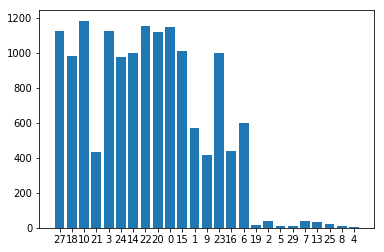

In [50]:
plt.bar(range(len(errorAnalysis)), list(errorAnalysis.values()), align='center')
plt.xticks(range(len(errorAnalysis)), list(errorAnalysis.keys()))
plt.show()

In [51]:
inverseMapping

{0: 'age',
 1: 'class_of_worker',
 2: 'education',
 3: 'enroll_in_edu_inst_last_wk',
 4: 'marital_stat',
 5: 'major_industry_code',
 6: 'major_occupation_code',
 7: 'race',
 8: 'hispanic_origin',
 9: 'sex',
 10: 'member_of_a_labor_union',
 11: 'reason_for_unemployment',
 12: 'full_or_part_time_employment_stat',
 13: 'tax_filer_stat',
 14: 'region_of_previous_residence',
 15: 'state_of_previous_residence',
 16: 'detailed_household_and_family_stat',
 17: 'detailed_household_summary_in_household',
 18: 'migration_code_change_in_msa',
 19: 'migration_code_change_in_reg',
 20: 'migration_code_move_within_reg',
 21: 'live_in_this_house_1_year_ago',
 22: 'migration_prev_res_in_sunbelt',
 23: 'country_of_birth_father',
 24: 'country_of_birth_mother',
 25: 'country_of_birth_self',
 26: 'citizenship',
 27: 'own_business_or_self_employed',
 28: 'year',
 29: 'income'}

In [52]:
print("Repair time:" + str(time.time()-start))

Repair time:4255.998773097992
